# Convolutionnal Generative Adversarial Networks
## Initialisation and dataset preparation

First, let us import the required libraries.

In [1]:
import tensorflow as tf
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, stft, istft
import matplotlib.pyplot as plt
import librosa
import librosa.display
from misceallaneous import getWavFileAsNpArray, displaySpectrogram
from IPython.display import Audio

Then, let us include the dataset.

The dataset is made of two files: `clean/p1.wav`and `white/p1.wav` which are converted into arrays of `int32` and then split into segments of `samples_length`.

The goal of the CGAN here is to predict the clean sample, when fed with the white one.

In [2]:
samplerate = 12000
nperseg = 1024

clean = getWavFileAsNpArray("../dataset_2/clean/p1.wav")
white = getWavFileAsNpArray("../dataset_2/white/p1.wav")
clean = np.array(clean, dtype="int32")
white = np.array(white, dtype="int32")

clean_dataset = []
white_dataset = []

samples_length = nperseg

for i in range(0, clean.shape[0]-samples_length, samples_length):
    clean_dataset.append(clean[i:i+samples_length])
    white_dataset.append(white[i:i+samples_length])
clean_dataset = np.array(clean_dataset)
white_dataset = np.array(white_dataset)

The size of the data set is (in the shape `(number of segments, segment size)`:

In [3]:
print(clean_dataset.shape)
print(white_dataset.shape)

(10659, 1024)
(10659, 1024)


## STFT Datasets

In [4]:
stft_clean_dataset_real = []
stft_clean_dataset_imag = []
stft_white_dataset_real = []
stft_white_dataset_imag = []

for i in clean_dataset:
    c, t, inp = stft(i, fs=samplerate, nperseg=nperseg)
    stft_clean_dataset_real.append(np.real(inp).T)
    stft_clean_dataset_imag.append(np.imag(inp).T)
    
for i in white_dataset:
    c, t, inp = stft(i, fs=samplerate, nperseg=nperseg)
    stft_white_dataset_real.append(np.real(inp).T)
    stft_white_dataset_imag.append(np.imag(inp).T)

stft_clean_dataset_real = np.array(stft_clean_dataset_real)
stft_clean_dataset_imag = np.array(stft_clean_dataset_imag)
stft_white_dataset_real = np.array(stft_white_dataset_real)
stft_white_dataset_imag = np.array(stft_white_dataset_imag)
print(stft_clean_dataset_real.shape, stft_clean_dataset_imag.shape, stft_white_dataset_real.shape, stft_white_dataset_imag.shape)

(10659, 3, 513) (10659, 3, 513) (10659, 3, 513) (10659, 3, 513)


## Test visualisation
We create an array `Vxx_input_test` which is displayed to show the typical content of the clean aimed output.

It is built from the five first samples of the clean dataset.

The function `displaySpectrogram` is defined in the file `miscellaneous.py`.

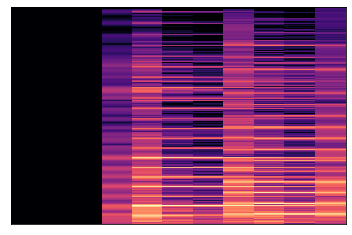

In [5]:
input_test0 = np.reshape(clean_dataset[0, :], (1, clean_dataset.shape[1]))
input_test1 = np.reshape(clean_dataset[1, :], (1, clean_dataset.shape[1]))
input_test2 = np.reshape(clean_dataset[2, :], (1, clean_dataset.shape[1]))
input_test3 = np.reshape(clean_dataset[3, :], (1, clean_dataset.shape[1]))
input_test4 = np.reshape(clean_dataset[4, :], (1, clean_dataset.shape[1]))
b0 = np.reshape(input_test0.T, (clean_dataset.shape[1],))
b1 = np.reshape(input_test1.T, (clean_dataset.shape[1],))
b2 = np.reshape(input_test2.T, (clean_dataset.shape[1],))
b3 = np.reshape(input_test3.T, (clean_dataset.shape[1],))
b4 = np.reshape(input_test4.T, (clean_dataset.shape[1],))
b = np.concatenate((b0, b1, b2, b3, b4))

c, t, Vxx_input_test = stft(b, fs=samplerate, nperseg=nperseg)
displaySpectrogram(Vxx_input_test)
plt.show()

# CGAN Model
The main idea of a GAN model is to create two networks who play an adversarial game:
- A Generator, whose goal is to produce the most realistic samples possible to fool the Discriminator
- A Discriminator, whose goal is to correctly guess if its input is a real sample from the clean dataset or an output created by the Generator

### Discriminator

The discriminator here uses a layer to process the Short-Time Fourier Transform (https://en.wikipedia.org/wiki/Short-time_Fourier_transform) before reducing the problem dimension to one single boolean prediction layer.

In [6]:
def process_stft(inputs):
    return tf.math.real(tf.signal.stft(inputs, frame_length=nperseg, frame_step=nperseg, pad_end=True))
def process_stft_imag(inputs):
    return tf.math.imag(tf.signal.stft(inputs, frame_length=nperseg, frame_step=nperseg, pad_end=True))

The model is then only a bunch of Dense layers bringing the processed input (of size `samples_length`) to an output of shape `(1)`.

In [9]:
  class ISTFTLayer(tf.keras.layers.Layer):
    def __init__(self, size):
        super(ISTFTLayer, self).__init__()
        self.size = size
        
    def call(self, inputs):
        input_shape = tf.shape(inputs)
        return tf.reshape(process_istft(inputs), (self.compute_output_shape(tf.shape(inputs))))

    def compute_output_shape(self, input_shape):
        return (-1, self.size)

In [143]:
def stft_discriminator(input_shape):
    inputs = tf.keras.Input(shape=(input_shape[1], input_shape[2]))
    x2 = tf.keras.layers.Dense(512, activation="tanh")(inputs)
    x3 = tf.keras.layers.Dense(256, activation="tanh")(x2)
    x4 = tf.keras.layers.Dense(128, activation="tanh")(x3)
    x5 = tf.keras.layers.Dense(1, activation="tanh")(x4)
    x6 = tf.keras.layers.Flatten()(x5)
    outputs = tf.keras.layers.Dense(1, activation="tanh")(x6)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="discriminator")
    model.summary()
    model.compile(optimizer= 'adam', loss='mse', metrics=['accuracy'])
    return model

And, in the current case, the discriminator is fed with inputs of size:

In [144]:
samples_length

1024

In [145]:
d = stft_discriminator(stft_white_dataset_real.shape)

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_128 (InputLayer)       [(None, 3, 513)]          0         
_________________________________________________________________
dense_157 (Dense)            (None, 3, 512)            263168    
_________________________________________________________________
dense_158 (Dense)            (None, 3, 256)            131328    
_________________________________________________________________
dense_159 (Dense)            (None, 3, 128)            32896     
_________________________________________________________________
dense_160 (Dense)            (None, 3, 1)              129       
_________________________________________________________________
flatten_20 (Flatten)         (None, 3)                 0         
_________________________________________________________________
dense_161 (Dense)            (None, 1)               

### Training the discriminator
The training phase of the discriminator is performed on an input dataset made of two parts:
- The real clean samples (labelled as `0`)
- The samples output by the generator (labelled as `1`)

In [148]:
def train_discriminator_on_batch(d, clean_samples, generator_samples, train_size=5000, verbose=True):
    input_dataset = []
    output_dataset = np.concatenate((np.zeros((train_size//2,)), np.ones((train_size//2,))))
    for i in range(train_size//2):
        input_dataset.append(clean_samples[i])
    for i in range(train_size//2):
        input_dataset.append(generator_samples[i])    
    history = d.fit(np.array(input_dataset), output_dataset, batch_size=16, verbose=verbose)
    return np.mean(history.history['accuracy'])

#### Pretraining the discriminator

313/313 [==============================] - 1s 4ms/step - loss: 0.2396 - accuracy: 0.5580


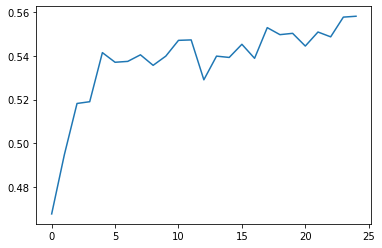

In [149]:
accuracies = []
for _ in range(25):
    accuracies.append(train_discriminator_on_batch(d, stft_clean_dataset_real, stft_white_dataset_real, verbose=True))
plt.plot(accuracies)

## Generator
The generator itself is a Convolutionnal Autoencoder.

Its input size and output size are both `sample_length`.

In [11]:
def create_complex_layer(inputs):
    return tf.complex(inputs[0], inputs[1])
def process_istft(inputs):
    p = tf.signal.inverse_stft(inputs, frame_length=nperseg, frame_step=nperseg, window_fn = tf.signal.inverse_stft_window_fn(nperseg))
    return tf.where(tf.math.is_nan(p), 0.0, p)

In [12]:
test = np.array(input_test1, dtype='float32')
#print(test)
x = process_istft(create_complex_layer((process_stft(test), process_stft_imag(test))))
print(x)
#plt.plot(test[0])

tf.Tensor(
[[0.0000000e+00 2.0949368e+00 1.5192417e+00 ... 3.8715171e+03
  7.4609785e+03 7.0918418e+03]], shape=(1, 1024), dtype=float32)


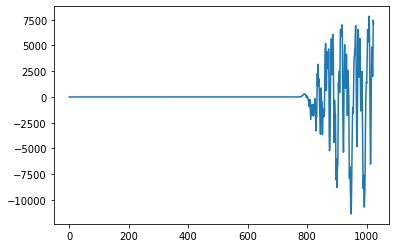

In [13]:
plt.plot(x[0])

In [14]:
  class ISTFTLayer(tf.keras.layers.Layer):
    def __init__(self, size):
        super(ISTFTLayer, self).__init__()
        self.size = size
        
    def call(self, inputs):
        input_shape = tf.shape(inputs)
        return tf.reshape(process_istft(inputs), (self.compute_output_shape(tf.shape(inputs))))

    def compute_output_shape(self, input_shape):
        return (-1, self.size)

Below, a tentative of STFT GAN: the complex part obtained is split into two layers: the real one (x0) and the imaginary one (y0).

The real part is processed through an autoencoder, before being re-added to the imaginary part. 

Then, the inverse STFT is processed.

It seems clear that the training process is impossible since there is no clear link between the output and the inner layers (since the inner layers are wrapped between STFT and inverse STFT layers).

Therefore, it could be a good approach to process the STFT on the input and expected data, and to train a GAN on the STFT.



In [15]:
def stft_generator(size):
    inputs = tf.keras.Input(shape=(size,))
    x0 = tf.keras.layers.Lambda(process_stft)(inputs)
    x1 = tf.keras.layers.Dense(513, activation='selu')(x0)    
    y0 = tf.keras.layers.Lambda(process_stft_imag)(inputs)
    z0 = tf.keras.layers.Lambda(create_complex_layer)((x1, y0))
    z1 = ISTFTLayer(size)(z0) 
    model = tf.keras.Model(inputs=inputs, outputs=z1, name="stft_autoencoder")
    model.summary()
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model

#g = stft_generator(samples_length)

Hereunder is another attempt of autoencoder, with one skip connection between the input and the last layer.
This comes from the assumption that there is a great part of the information in the input that could be used in itself to predict the output.

This architecture is quite simple, and lead to a slow (and not really convincing) learning, despite the facts that it learns.

In [72]:
def generator(size):
    inputs = tf.keras.Input(shape=(size,))
    x0 = tf.keras.layers.Dense(512, activation='tanh')(inputs)
    x01 = tf.keras.layers.Reshape((512, -1))(x0)
    x02 = tf.keras.layers.MaxPooling1D(4, padding='same')(x01)
    x03 = tf.keras.layers.MaxPooling1D(4, padding='same')(x02)
    x04 = tf.keras.layers.Flatten()(x03)
    x1 = tf.keras.layers.Dense(128, activation='tanh')(x04)
    x2 = tf.keras.layers.Dense(512, activation='tanh')(x1)
    x21 = tf.keras.layers.Add()([x0, x2])
    x4 = tf.keras.layers.Dense(size, activation='tanh')(x21)
    x5 = tf.keras.layers.Add()([inputs, x4])
    outputs = tf.keras.layers.Dense(size, activation='linear')(x5)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="autoencoder")
    model.summary()
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 1024)]       0                                            
__________________________________________________________________________________________________
dense_87 (Dense)                (None, 512)          524800      input_23[0][0]                   
__________________________________________________________________________________________________
reshape_17 (Reshape)            (None, 512, 1)       0           dense_87[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_2 (MaxPooling1D)  (None, 128, 1)       0           reshape_17[0][0]                 
________________________________________________________________________________________

In [200]:
def generator(size):
    inputs = tf.keras.Input(shape=(size,))
    inputs_drop = tf.keras.layers.Dropout(0.01)(inputs)
    x = tf.keras.layers.Dense(size, activation='linear')(inputs_drop)
    
    x0 = tf.keras.layers.Reshape((size, -1))(x)
    
    x1 = tf.keras.layers.Conv1D(4, 16, activation='tanh', padding='same')(x0)
    x2 = tf.keras.layers.MaxPooling1D(2)(x1)
    
    x3 = tf.keras.layers.Conv1D(4, 16, activation='tanh', padding='same')(x2)
    x4 = tf.keras.layers.MaxPooling1D(2)(x3)
    
    x5 = tf.keras.layers.Conv1D(4, 16, activation='tanh', padding='same')(x4)
    x6 = tf.keras.layers.MaxPooling1D(2)(x5)
    
    x7 = tf.keras.layers.Conv1D(4, 16, activation='tanh', padding='same')(x6)
    x8 = tf.keras.layers.MaxPooling1D(2)(x7)
    
    x9 = tf.keras.layers.Flatten()(x8)
    x12 = tf.keras.layers.Dense(size, activation='relu')(x9)
    g = tf.keras.layers.Add()([x, x12])
    outputs = tf.keras.layers.Dense(size, activation='linear')(g)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="autoencoder")
    model.summary()
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model


In [238]:
inputs = []
outputs = []
for i in range(10):
    x = np.reshape(white_dataset[i, :], (1, white_dataset.shape[1]))
    y = np.reshape(white_dataset[i, :], (1, white_dataset.shape[1]))
    y1 = g.predict(y)
    x2 = np.reshape(x.T, (clean_dataset.shape[1],))
    y2 = np.reshape(y1.T, (clean_dataset.shape[1],))
    inputs.append(x2)
    outputs.append(y2)

a = np.concatenate(inputs)
b = np.concatenate(outputs)

c, t, axx = stft(a, fs=samplerate, nperseg=nperseg)
c, t, bxx = stft(b, fs=samplerate, nperseg=nperseg)
displaySpectrogram(axx)
plt.show()
displaySpectrogram(bxx)
plt.show()

ValueError: in user code:

    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer autoencoder: expected shape=(None, 513, 3), found shape=(None, 1024)


Below is the first generator to give great results (in accuracy): 92% after 25 epochs.
However, the resulting sound in wobbly, but it can be used in the GAN architecture.

In [124]:
def generator_on_stft(sizes):
    inputs = tf.keras.Input(shape=(sizes[1], sizes[2]))
    x = tf.keras.layers.Dense(128, activation='tanh')(inputs)
    x1 = tf.keras.layers.Dense(sizes[2], activation='tanh')(x)
    x2 = tf.keras.layers.Add()([inputs, x1])
    outputs = tf.keras.layers.Dense(sizes[2], activation='linear')(x2)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="autoencoder")
    model.summary()
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model

g = generator_on_stft(stft_white_dataset_real.shape)

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_104 (InputLayer)          [(None, 3, 513)]     0                                            
__________________________________________________________________________________________________
dense_133 (Dense)               (None, 3, 128)       65792       input_104[0][0]                  
__________________________________________________________________________________________________
dense_134 (Dense)               (None, 3, 513)       66177       dense_133[0][0]                  
__________________________________________________________________________________________________
add_16 (Add)                    (None, 3, 513)       0           input_104[0][0]                  
                                                                 dense_134[0][0]        

### Pretraining the generator

667/667 [==============================] - 3s 5ms/step - loss: 162.3258 - accuracy: 0.9301


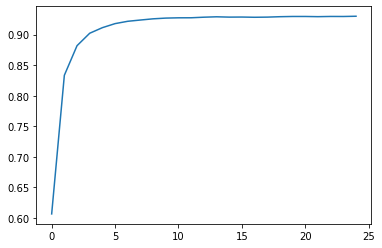

In [96]:
accuracies = []
for _ in range(25):
    accuracies.append(g.fit(stft_white_dataset_real, stft_clean_dataset_real, batch_size=16, verbose=1).history["accuracy"])
plt.plot(accuracies)

(10659, 3, 513)
(1, 3, 513)


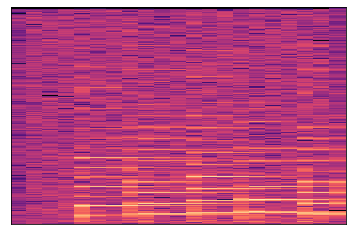

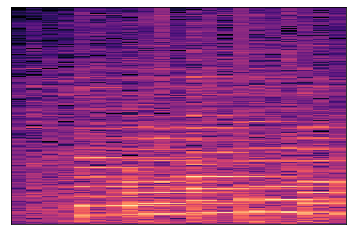

In [97]:
inputs = []
outputs = []
print(stft_white_dataset_real.shape)
print(np.reshape(stft_white_dataset_real[i, :, :], (-1, stft_white_dataset_real.shape[1], stft_white_dataset_real.shape[2])).shape)
for i in range(10):
    x = np.reshape(white_dataset[i, :].T, (1, white_dataset.shape[1]))
    y = np.reshape(stft_white_dataset_real[i, :, :], (-1, stft_white_dataset_real.shape[1], stft_white_dataset_real.shape[2]))
    t, y1 = istft(np.reshape(g.predict(y).T, (513, 3))+np.imag(stft_white_dataset_imag[i]).T)
    x2 = np.reshape(x.T, (clean_dataset.shape[1],))
    y2 = np.reshape(y1.T, (clean_dataset.shape[1],))
    inputs.append(x2)
    outputs.append(y2)

a = np.concatenate(inputs)
b = np.concatenate(outputs)

c, t, axx = stft(a, fs=samplerate, nperseg=nperseg)
c, t, bxx = stft(b, fs=samplerate, nperseg=nperseg)
displaySpectrogram(axx)
plt.show()
displaySpectrogram(bxx)
plt.show()

In [98]:
Audio(a, rate=samplerate)

In [99]:
Audio(b, rate=samplerate)

## Building the GAN

In [292]:
def get_generator_outputs(white, train_size, g, nperseg, clean):
    rng = np.random.default_rng()
    g_outputs = []
    batch = rng.choice(white, train_size)
    for i in range(train_size):
        t = np.reshape(white[i, :, :], (-1, white.shape[1], white.shape[2]))
        m = g.predict(t)
        g_outputs.append(m)
    g_outputs = np.reshape(np.array(g_outputs), (train_size,  white.shape[1], white.shape[2]))
    input_data = np.concatenate((g_outputs, clean[:train_size,]))
    output_data = np.concatenate((-1*np.ones((train_size,)), np.ones((train_size,))))
    return input_data, output_data

In [300]:
class GAN:
    def __init__(self, size, g, d):
        self.g = g
        self.d = d
        self.z = tf.keras.layers.Input(shape=(size[1],size[2]))
        self.image = self.g(self.z)
        self.valid = self.d(self.image)
        self.combined_network = tf.keras.Model(self.z, self.valid)
        self.compile()
    def block_discriminator(self):
        self.d.trainable = False
        self.g.trainable = True
        self.compile()
    def block_generator(self):
        self.g.trainable = False
        self.d.trainable = True
        self.compile()
    def compile(self):
        self.combined_network.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
        #combined_network.summary()

g = generator_on_stft(stft_white_dataset_real.shape)
d = stft_discriminator(stft_white_dataset_real.shape)

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_231 (InputLayer)          [(None, 3, 513)]     0                                            
__________________________________________________________________________________________________
dense_349 (Dense)               (None, 3, 128)       65792       input_231[0][0]                  
__________________________________________________________________________________________________
dense_350 (Dense)               (None, 3, 513)       66177       dense_349[0][0]                  
__________________________________________________________________________________________________
add_48 (Add)                    (None, 3, 513)       0           input_231[0][0]                  
                                                                 dense_350[0][0]        

In [301]:
def train_on_batch(d, i, o, verbose=True):  
    history = d.fit(i, o, batch_size=16, verbose=verbose)
    return np.mean(history.history['accuracy'])

In [302]:
train_size = 10000
g_accuracy = 0
d_accuracy = 0

In [303]:
gan = GAN(stft_white_dataset_real.shape, g, d)
for _ in range(10):
    if d_accuracy < 1:
        i, o = get_generator_outputs(stft_white_dataset_real, train_size, gan.g, nperseg, stft_clean_dataset_real)
    gan.block_generator()
    while d_accuracy <= g_accuracy and d_accuracy < 1:
        d_accuracy = train_on_batch(gan.d, i, o, verbose=False)
        print("Discriminator accuracy:", d_accuracy)
    gan.block_discriminator()
    while g_accuracy <= d_accuracy and g_accuracy < 1:
        g_accuracy = train_on_batch(gan.combined_network, stft_white_dataset_real[:train_size,], np.ones(train_size), verbose=False)
        print("Generator accuracy:", g_accuracy)

    inputs = []
    outputs = []
    print(stft_white_dataset_real.shape)
    #print(np.reshape(stft_white_dataset_real[i,], (-1, stft_white_dataset_real.shape[1], stft_white_dataset_real.shape[2])).shape)
    for i in range(10):
        y = np.reshape(stft_white_dataset_real[i, ], (-1, stft_white_dataset_real.shape[1], stft_white_dataset_real.shape[2]))
        t, y1 = istft(np.reshape(gan.g.predict(y).T, (513, 3))+np.imag(stft_white_dataset_imag[i]).T)
        y2 = np.reshape(y1.T, (clean_dataset.shape[1],))
        outputs.append(y2)

    b = np.concatenate(outputs)
    c, t, bxx = stft(b, fs=samplerate, nperseg=nperseg)
    displaySpectrogram(bxx)
    plt.show()

Discriminator accuracy: 0.03999999910593033
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 

Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accura

Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accura

Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accuracy: 0.0
Generator accura

KeyboardInterrupt: 

In [ ]:
Audio(a, rate=samplerate)

In [ ]:
Audio(b, rate=samplerate)